# 1A. Importing dependencies

In [33]:
import mesa
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

# 1B. Helper Functions

In [34]:
def get_distance(pos_1, pos_2):
    '''
    Getting the euclidian distance by using the pytaghorean theorem

    used in trade.move()
    '''

    x1, x2, = pos_1
    y1, y2 = pos_2

    dx = x1 - x2
    dy = y1 - y2

    return math.sqrt(dx**2 + dy**2)

# 2. Resource Classes

In [35]:
class Sugar(mesa.Agent):
    '''
    Sugar:
    - Contains an amount of sugar
    - Grows one amount of sugar at each turn
    '''

    def __init__(self, unique_id, model, pos, max_sugar):
        super().__init__(unique_id, model)
        self.pos = pos
        self.amount = max_sugar
        self.max_sugar = max_sugar

    def step(self):
        '''
        Sugar Growth function:
        Adds one unit of sugar each step until max_sugar is met
        '''
        self.amount = min([self.max_sugar, self.amount+1])
        

In [36]:
class Spice(mesa.Agent):
    '''
    Spice:
    - Contains an amount of spice
    - Grows one amnount of spice at each turn
    '''

    def __init__(self, unique_id, model, pos, max_spice):
        super().__init__(unique_id, model)
        self.pos = pos
        self.amount = max_spice
        self.max_spice = max_spice

    def step(self):
        '''
        Spice growth function:
        Adds one unit of spice each step until max_spice is met
        '''
        self.amount = min([self.max_spice, self.amount+1])

# 3. Trader Class

In [181]:
class Trader(mesa.Agent):
    '''
    Trader:
    - Has a metabolism for sugar and spice
    - Harvests and trade sugar and spice to survive and thrive
    '''

    def __init__(self, unique_id, model, pos, moore=False, sugar=0,
                 spice=0,metabolism_sugar=0,metabolism_spice=0,
                 vision=0):

        super().__init__(unique_id,model)
        self.pos = pos
        self.moore = moore
        self.sugar = sugar
        self.spice = spice
        self.metabolism_sugar = metabolism_sugar
        self.metabolism_spice = metabolism_spice
        self.vision = vision

    ################################
    ### RESOURCE CHECK FUNCTIONS ###
    ################################

    def get_sugar(self, pos):
        this_cell = self.model.grid.get_cell_list_contents(pos)
        for agent in this_cell:
            if type(agent) is Sugar:
                return agent
        return None

    def get_sugar_amount(self, pos):
        '''
        Helper function of calculate_welfare()
        Get sugar amount of cells around agent
        '''
        sugar_patch = self.get_sugar(pos)
        if sugar_patch:
            return sugar_patch.amount
        return 0
    
    def get_spice(self, pos):
        this_cell = self.model.grid.get_cell_list_contents(pos)
        for agent in this_cell:
            if type(agent) is Spice:
                return agent
        return None
    
    def get_spice_amount(self, pos):
        '''
        Helpter function of calculate_welfare()
        Get spice amount of cells around agent
        '''
        spice_patch = self.get_spice(pos)
        if spice_patch:
            return spice_patch.amount
        return 0

    ##############################
    ### TRADER CHECK FUNCTIONS ###
    ##############################

    def get_trader(self, pos):
        '''
        Helper function of self.trade_with_neighbors()


        '''
        this_cell = self.model.grid.get_cell_list_contents(pos)

        for agent in this_cell:
            if isinstance(agent, Trader):
                return agent


    def is_occupied_by_other(self, pos):
        '''
        Helper function part of self.move
        Check if a cell is occupied
        '''
        if pos == self.pos:
            # agent position is considered unoccupied as agent can stay there
            return False
        this_cell = self.model.grid.get_cell_list_contents(pos)
        for a in this_cell:
            # see if occupied by another agent
            if isinstance(a, Trader):
                return True
        return False
    

    ##################################
    ### TRADER BEHAVIOUR FUNCTIONS ###
    ##################################

    def calculate_welfare(self, sugar, spice):
        '''
        Helper function of self.move

        '''
        # Calculate total resources that the agent has
        m_total =  self.metabolism_sugar + self.metabolism_spice

        # Cobb douglas function:
        ## https://inomics.com/terms/cobb-douglas-production-function-1456726

        return sugar**(self.metabolism_sugar/m_total) * spice**(self.metabolism_spice/m_total)
    
    def is_starved(self):
        '''
        Helper function for maybe_die()
        '''
        # This returns True:
        return (self.sugar <= 0) or (self.spice <= 0)
    
    def calculate_MRS(self):
        '''
        Helper function of self.trade():
        
        Determine what the agent needs and what they are willing to give up
        '''

        return (self.spice/self.metabolism_spice) / (self.sugar/self.metabolism_sugar)
    
    def calculate_sell_spice_amount(self, price):
        '''
        Helper function of maybe_sell_spice
        '''
        if price >= 1:
            sugar = 1
            spice = int(price)
        else:
            sugar = int(1/price)
            spice = 1
        return sugar, spice

    
    def maybe_sell_spice(self, other, price, welfare_self, welfare_other):
        '''
        Helper function of self.trader()
        '''

        sugar_exchanged, spice_exchanged = self.calculate_sell_spice_amount(price)

        # Assess new sugar and spice amount - What if change did occur
        self_sugar = self.sugar + sugar_exchanged
        other_sugar = other.sugar - sugar_exchanged

        self_spice = self.spice - spice_exchanged
        other_spice = other.spice + spice_exchanged

        # Double check to ensure agents have resources

        if ((self_sugar <= 0) or (other_sugar <= 0) or (self_spice <= 0) or (other_spice <= 0)):
            return False
        
        # Trade criteria 1 - Are both agents better off?
        both_agents_better_off = (welfare_self < self.calculate_welfare(self_sugar, self_spice) 
                                  and 
                                  (welfare_other < other.calculate_welfare(other_sugar, other_spice)))

        # Trade criteria 2 - Is their MRS crossing?
        mrs_not_crossing = self.calculate_MRS() > other.calculate_MRS()

        print(both_agents_better_off)
        print('break')
        print(mrs_not_crossing)


    
    def trade(self, other):
        '''
        Helper function of self.trader_with_neighbors()

        Other is a trader agent object
        '''

        # Checking if the agents have sugar and spice
        assert self.sugar > 0
        assert self.spice > 0 
        assert other.sugar > 0
        assert other.spice > 0 

        # calculate marginal rate of substitution in Growing Artificial Societies p.103
        mrs_self = self.calculate_MRS()
        mrs_other = other.calculate_MRS()

        # calculate each agents welfare
        welfare_self = self.calculate_welfare(self.sugar, self.spice)
        welfare_other = other.calculate_welfare(other.sugar, other.spice)

        if math.isclose(mrs_self, mrs_other, rel_tol=1e-02):
            return

        # calculate price
        price = math.sqrt(mrs_self*mrs_other)
        
        if mrs_self > mrs_other:
            solde = self.maybe_sell_spice(other, price, welfare_self, welfare_other)

    
    ###########################
    ### MOVING AGENT TRADER ###
    ###########################

    def move(self):
        '''
        Function for trader agent to identify optimal move for each step
        1 - Identify all possible moves
        2 - Determine which move maximise welfare
        3 - Find closest best option
        4 - Move
        '''
        
        # 1 - Identify all possible moves

        ## This gives us a list of ALL possible locations our Trade can go
        ## This is based on their "vision", and takes into consideration cells that are already occupied
        neighbors = [i
                      for i in self.model.grid.get_neighborhood(
                        self.pos, self.moore, True, self.vision
                      ) if not self.is_occupied_by_other(i)]
        
        # 2 - Determine which move maximises welfare
        welfares = [
            self.calculate_welfare(
                self.sugar + self.get_sugar_amount(pos), 
                self.spice + self.get_spice_amount(pos)) 
            for pos in neighbors
        ]
        
        # 3 - Find closest best option

        ## find the highest welfare in welfares 
        max_welfare = max(welfares)

        ## get the index of max welfare cells
        candidate_indices = [i for i in range(len(welfares))
                             if math.isclose(welfares[i], max_welfare, rel_tol=1e-02)]
        
        ## convert index to positions of those cells
        candidates = [neighbors[i] for i in candidate_indices]
        
        min_dist = min(get_distance(self.pos, pos) for pos in candidates)

        final_candidates = [ pos for pos in candidates
                            if math.isclose(get_distance(self.pos, pos), min_dist, rel_tol=1e-02)

                            ]
        
        self.random.shuffle(final_candidates)

        # 4. Move agents
        ## get the shuffled list of final candidates and move to the first one
        self.model.grid.move_agent(self, final_candidates[0])

    ##############################
    ### EATING SUGAR AND SPICE ###
    ##############################
    
    def eat(self):
        '''
        Function for trader to eat sugar and spice
        '''
        # get sugar
        sugar_patch = self.get_sugar(self.pos)

        # eat sugar
        if sugar_patch:
            self.sugar = self.sugar - self.metabolism_sugar + sugar_patch.amount
            sugar_patch.amount = 0

        # get spice
        spice_patch = self.get_spice(self.pos)

        # eat spice
        if spice_patch:
            self.spice = self.spice - self.metabolism_spice + spice_patch.amount
            spice_patch.amount = 0

    ###################
    ### MAYBE DYING ###
    ###################

    def maybe_die(self):
        '''
        Function to remove Traders who have run out of sugar OR spice
        '''

        if self.is_starved(): 
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)

    ###################
    ### TRADING ###
    ###################

    def trade_with_neighbors(self):
        '''
        Function for trader agents to decide who to trade with in three parts

        1 - Identify neighbors who can trader
        2 - Trade
        3 - Collect data

        '''
        neighbor_agents = [self.get_trader(pos) for pos in self.model.grid.get_neighborhood(
        self.pos, self.moore, False, self.vision) if self.is_occupied_by_other(pos)
        ]

        if len(neighbor_agents) == 0:
            # trade returns price and trade network (who agent traded with)
            return [],[]

        # Iterate through traders in neighboring cells and trade
        for a in neighbor_agents:
            if a:
                self.trade(a)

# 4. Model Class

In [182]:
class SugarscapeG1mt(mesa.Model):
    '''
    A model class to manage sugarscape with traders (G1mt)
    from: Growing artificial societies 1996
    '''
    def __init__(
            self, width=50,height=50, 
            initial_population=200,
            endowment_min=25,endowment_max=50, 
            metabolism_min=1,metabolism_max=5,
            vision_min=1,vision_max=5
                 ):

        # Inititiate width and heigth of sugarscape
        self.width = width
        self.height = height
        self.initial_population = initial_population
        self.endowment_min = endowment_min
        self.endowment_max = endowment_max
        self.metabolism_min = metabolism_min
        self.metabolism_max = metabolism_max
        self.vision_min = vision_min
        self.vision_max = vision_max


        # Initiate scheduler
        self.schedule = mesa.time.RandomActivationByType(self)

        
        # Initiate mesa grid class
        self.grid = mesa.space.MultiGrid(self.width, self.height, torus=False)

        # Read in landscape file from supplementary material
        sugar_distribution = np.genfromtxt('sugar-map.txt')
        spice_distribution = np.flip(sugar_distribution, 1)
        
        agent_id = 0

        for _,x,y in self.grid.coord_iter():

            max_sugar = sugar_distribution[x, y]
            if max_sugar > 0:
                sugar = Sugar(agent_id, self, (x, y), max_sugar)
                self.grid.place_agent(sugar, (x, y))
                self.schedule.add(sugar)
                agent_id += 1
        
        for _,x,y in self.grid.coord_iter():

            max_spice = spice_distribution[x, y]
            if max_spice > 0:
                spice = Spice(agent_id, self, (x, y), max_spice)
                self.grid.place_agent(spice, (x, y))
                self.schedule.add(spice)
                agent_id += 1

        for i in range(self.initial_population):
            # get each agent position
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)

            # Giver agents initial endowment
            sugar = int(self.random.uniform(self.endowment_min, self.endowment_max+1))
            spice = int(self.random.uniform(self.endowment_min, self.endowment_max+1))

            # giver agents initial metabolism
            metabolism_sugar = int(self.random.uniform(self.metabolism_min, self.metabolism_max+1))
            metabolism_spice = int(self.random.uniform(self.metabolism_min, self.metabolism_max+1))

            # Give agent vision
            vision = int(self.random.uniform(self.vision_min, self.vision_max))

            # Create a trader object
            trader = Trader(agent_id, 
                            self,
                            (x,y),
                            moore = False,
                            sugar = sugar,
                            spice = spice,
                            metabolism_sugar = metabolism_sugar,
                            metabolism_spice = metabolism_spice,
                            vision = vision
                            )
            
            # place agent
            self.grid.place_agent(trader, (x,y))
            self.schedule.add(trader)

            agent_id += 1
            
    #################################
    ### HELPER FUNCTIONS FOR STEP  ###
    #################################
    
    def randomize_traders(self):
        '''
        Helper function for step function
        creates randomized list of traders
        Used to avoid first mover advantages
        '''
        trader_shuffle = list(self.schedule.agents_by_type[Trader].values())
        self.random.shuffle(trader_shuffle)

        return trader_shuffle

    ###############################
    ### STEP THROUGH THE MODEL  ###
    ###############################

    def step(self):

        '''
        Unique step function to combine staged activation of sugar and spice
        and then randomly activates traders
        '''

        # step sugar agents
        for sugar in self.schedule.agents_by_type[Sugar].values():
            sugar.step()

        # step spice agents
        for spice in self.schedule.agents_by_type[Spice].values():
            spice.step()

        # step trader agents
        ## to account for agent death and removal, we need a separate data structure to iterate
        trader_shuffle = self.randomize_traders()

        ## Make Traders go through their behaviour functions:
        for agent in trader_shuffle:
            agent.move()
            agent.eat()
            agent.maybe_die()
        
        ## Running this again to guarantee that no "dead" traders are considered when trading:
        ## They are randomized to avoid first movers advantage
        trader_shuffle = self.randomize_traders()

        for agent in trader_shuffle:
            agent.trade_with_neighbors()
                
        self.schedule.steps += 1 # important for data collector to track the number of steps

    def run_model(self, step_count=1000):

        for i in range(step_count):
            print("Running step: ", str(i))
            self.step()

# 5. Run Sugarscape

In [183]:
model = SugarscapeG1mt()
model.run_model(step_count=5)

Running step:  0
False
break
True
False
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
False
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
False
break
True
False
break
True
False
break
True
True
break
True
False
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
False
break
True
True
break
True
True
break
True
True
break
True
True
break
True
False
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
True
True
break
Tru

# 6. Visualing the distribution of sugar and spice

In [167]:
sugar_distribution = np.genfromtxt('sugar-map.txt')
spice_distribution = np.flip(sugar_distribution, 1)

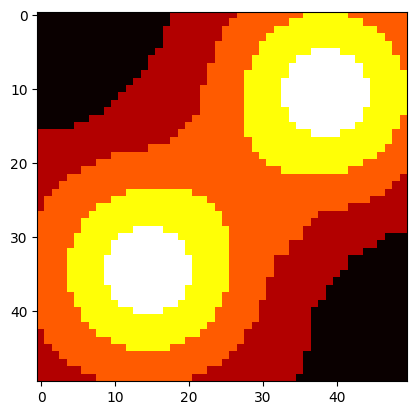

In [168]:
plt.imshow(sugar_distribution, cmap='hot', interpolation='nearest')

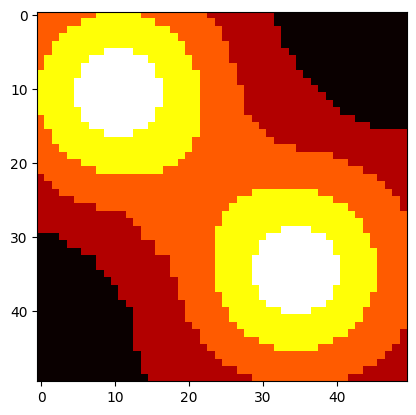

In [169]:
plt.imshow(spice_distribution, cmap='hot', interpolation='nearest')